In [1]:
using Plots,LinearAlgebra,Interpolations, Random, Distributions, Roots, NLopt, ForwardDiff, LaTeXStrings, DifferentialEquations
gr() #Install packages
a=zeros(2); α1=1.0; α2=-0.1; #Initial parameter estimates
T=LinRange(0,20,11);
Tf=LinRange(0,20,1001);
σ=3.0;

In [2]:
A=zeros(2,3) #Matrix storing elements of the eigenvectors that span the identifiable space
A[1,1]=0.013408677966214741
A[1,2]=0.013408677966214741
A[1,3]=0.9998201911895942
A[2,1]=-0.7069796371573925
A[2,2]=-0.7069796371573925
A[2,3]=0.018962734233314172
B = pinv(A); #Pseudo-inverse

In [3]:
function DE!(dx,x,p,t) #Set up ODE
α1,α2=p
k1 = B[1,1]*α1+B[1,2]*α2
k2 = B[2,1]*α1+B[2,2]*α2
p =  B[3,1]*α1+B[3,2]*α2
dx[1]=-(k1+k2)*x[1]+p 
end

DE! (generic function with 1 method)

In [4]:
function odesolver(T,α1,α2) #Set up ODE
p=(α1,α2)
x0=100.0;
tspan=(0.0,maximum(T));
prob=ODEProblem(DE!,[x0],tspan,p);
sol=solve(prob,saveat=T);
return sol[1,:]
end

odesolver (generic function with 1 method)

In [5]:
function model(T,a) #Solve model
y = Vector{eltype(a)}(undef, length(T))
y=odesolver(T,a[1],a[2])
return y
end

model (generic function with 1 method)

In [6]:
data=zeros(length(T));
data = [100.0
  67.40781240523978
  50.36739678330086
  28.639536169059387
  19.515392344072495
  14.371202354712407
  14.76153414167794
  10.755562239200433
   7.889196085316499
   7.604215329108149
   5.187073566537364]; #Data 

In [7]:
function loglhood(data,a,T,σ) #Loglikelihood function 
y=zeros(length(T)) 
y=model(T,a)
ℓ=0.0
data_dists=[Normal(0,σ) for mi in y];
ℓ+=sum([loglikelihood(data_dists[i],data[i] - y[i]) for i in 1:length(data_dists)]) 
return ℓ
end;

In [8]:
function funmle(a) #Loglikelihood function 
return loglhood(data,a,T,σ)
end;

In [9]:
function Optimise(fun,θ₀,lb,ub) #Optimisation with NLopt and Nelder-Mead
tomax=(θ,∂θ)->fun(θ)
opt=Opt(:LN_NELDERMEAD,length(θ₀))
opt.max_objective=tomax
opt.lower_bounds=lb      
opt.upper_bounds=ub
optmaxtime=1*60
res = optimize(opt,θ₀)
return res[[2,1]]
end;

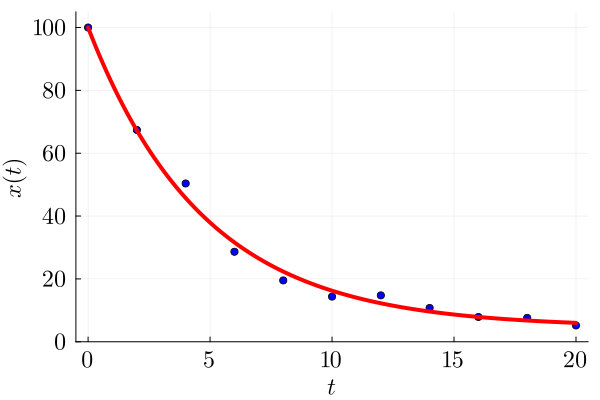

In [10]:
θG=[α1,α2] #Parameter estimates
lb=[-1,-1]; ub=[10,10] #Bounds
(xopt,fopt)=Optimise(funmle,θG,lb,ub)
fmle = fopt;
α1mle=xopt[1]; 
α2mle=xopt[2];
xmle=model(Tf,xopt);
p1=scatter(T,data,mc=:blue,msc=:match,label=false)
p1=plot!(Tf,xmle,lw=4,lc=:red,label=false,xlabel=L"t",ylabel=L"x(t)",xlims=(0,maximum(T)))
p1=plot!(xlims=(0-0.5,maximum(T)+0.5),xticks=([0,5,10,15,20],[L"0",L"5",L"10",L"15",L"20"]))
p1=plot!(ylims=(0,105),yticks=([0,20,40,60,80,100],[L"0", L"20", L"40",L"60",L"80",L"100"]))
p1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)
display(p1)
#savefig(p1,"ProductionDecay_MLE_RescaledSVD.pdf")

In [11]:
xopt

2-element Vector{Float64}:
  0.968625463623629
 -0.13033165796976787

In [12]:
ff(θ1,θ2) = funmle([θ1,θ2]) #Compute the observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> ff(z[1],z[2]),xopt)

2×2 Matrix{Float64}:
  4.92793        -9.95188e-5
 -9.95188e-5  35151.8

In [13]:
rank(H) #Compute the rank of the observed Fisher Information

2

In [14]:
(evals,evecs)=eigen(H) #Compute the eigenvectors and eigenvalues of the observed Fisher Informatio

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
     4.927933063715001
 35151.7612966215
vectors:
2×2 Matrix{Float64}:
 -1.0         -2.83151e-9
 -2.83151e-9   1.0

In [61]:
N=50;  #Set up grids and bounds for the univariate profile likelihood function computation
α1min=-0.5;  α1max=2.5;
α2min=-0.2; α2max=-0.10;
αα1=LinRange(α1min,α1max,N);
αα2=LinRange(α2min,α2max,N);

In [62]:
function ellipse(α1,α2,HH,xopt) #Function to compute the ellipse associated with the Wald interval
return -0.5*H[1,1]*(α1-xopt[1])^2-0.5*H[2,2]*(α2-xopt[2])^2-H[1,2]*(α1-xopt[1])*(α2-xopt[2]);
end

ellipse (generic function with 1 method)

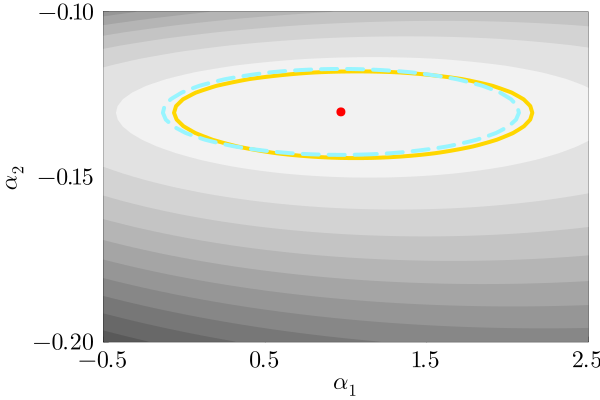

In [63]:
df=2 #Visualise the loglikelihood function, associated thresholds and MLE
llstar=-quantile(Chisq(df),0.95)/2
b1=contourf(αα1,αα2,(αα1,αα2)->funmle([αα1,αα2])-fopt,lw=0,xlabel=L"α_1",ylabel=L"α_2",c=:grays,colorbar=:false)
b1=scatter!([α1mle],[α2mle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b1=contour!(αα1,αα2,(αα1,αα2)->funmle([αα1,αα2])-fopt,levels=[llstar],lw=4,c=:gold,legend=false)
b1=contour!(αα1,αα2,(αα1,αα2)->ellipse(αα1,αα2,H,xopt),levels=[llstar],lw=4,ls=:dash,c=:cadetblue1,legend=false)
b1=plot!(xlims=(α1min,α1max),xticks=([-0.5,0.5,1.5,2.5],[L"-0.5", L"0.5",L"1.5",L"2.5"]))
b1=plot!(ylims=(α2min,α2max),yticks=([-0.20,-0.15,-0.10],[L"-0.20", L"-0.15",L"-0.10"]))
b1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b1)
#savefig(b1,"ProductionDecay_2DLikelihood_RescaledSVD.pdf")

In [64]:
#Univariate Profiles
df=1
llstar=-quantile(Chisq(df),0.95)/2;

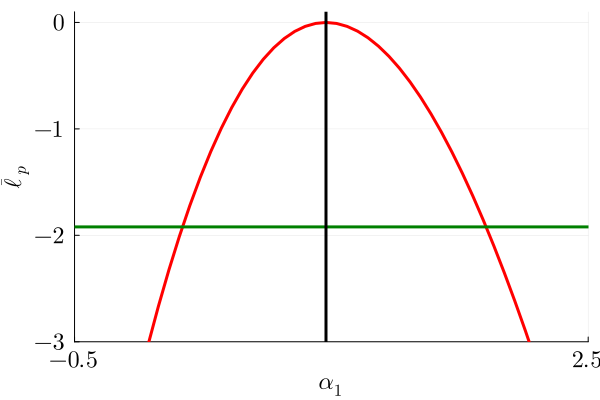

In [65]:
#Function to define univariate profile for α1
function Uα1(α1)
a=zeros(1)    
function funα1(a)
return loglhood(data,[α1,a[1]],T,σ) 
end
θG=[α2mle]
lb=[-1]
ub=[10]
(xopt,fopt)=Optimise(funα1,θG,lb,ub);
llb=fopt-fmle
return llb,xopt
end 
fα1(x) = Uα1(x)[1]

q1=plot(fα1,αα1,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q1=hline!([llstar],legend=false,lw=3,lc=:green)
q1=vline!([α1mle],lc=:black,legend=false,xlabel=L"α_1",ylabel=L"\bar{\ell}_p",lw=3)
q1=plot!(xlims=(minimum(αα1),maximum(αα1)),xticks=([-0.5,2.5],[L"-0.5",L"2.5"]))
q1=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

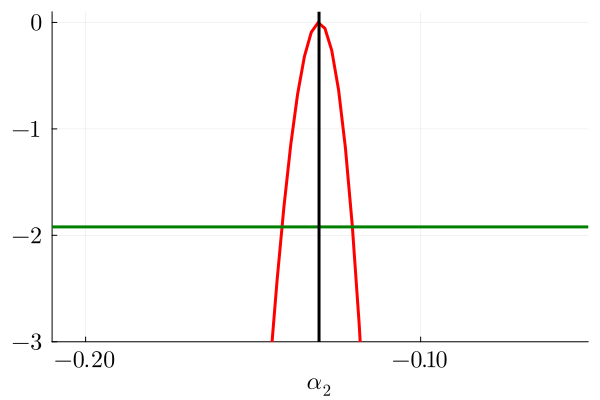

In [69]:
#Function to define univariate profile for α2  
function Uα2(α2)
a=zeros(1)    
function funα2(a)
return loglhood(data,[a[1],α2],T,σ) 
end
θG=[α1mle]
lb=[-1]
ub=[10]
(xopt,fopt)=Optimise(funα2,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fα2(x) = Uα2(x)[1]

q2=plot(fα2,αα2,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q2=hline!([llstar],legend=false,lw=3,lc=:green)
q2=vline!([α2mle],lc=:black,legend=false,xlabel=L"α_2",lw=3)
q2=plot!(xlims=(minimum(αα2)-0.01,maximum(αα2)+0.05),xticks=([-0.20,-0.10],[L"-0.20", L"-0.10"]))
q2=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q2=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

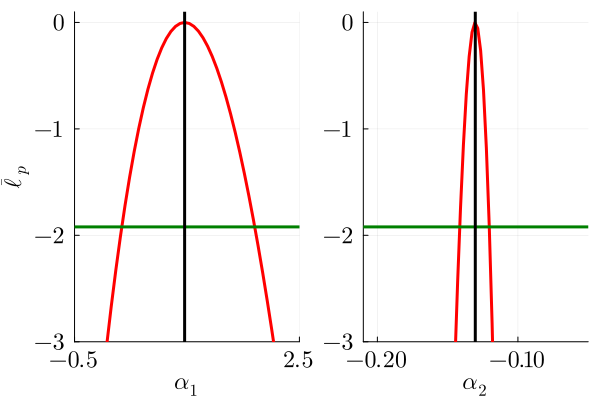

In [70]:
q4=plot(q1,q2,layout=(1,2))
display(q4)

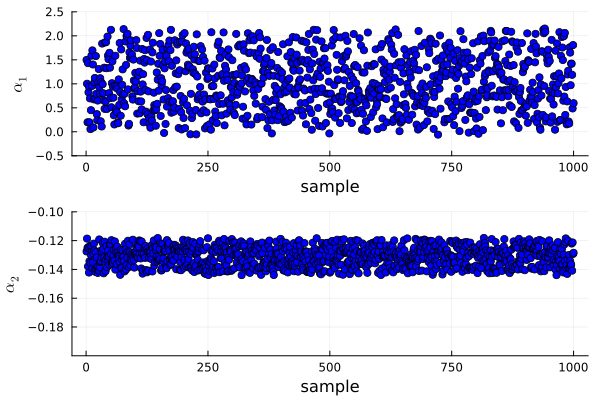

In [71]:
df=2 #Generate M parameter samples within the 95% confidence region by rejection sampling
llstar=-quantile(Chisq(df),0.95)/2
M=1000
α1sample=zeros(M)
α2sample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
α1g=rand(Uniform(α1min,α1max))
α2g=rand(Uniform(α2min,α2max))
    if (loglhood(data,[α1g,α2g],T,σ)-fmle) >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(data,[α1g,α2g],T,σ)-fmle
    α1sample[kount]=α1g;
    α2sample[kount]=α2g;    
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"α_1",ylims=(α1min,α1max))
a2=scatter(α2sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"α_2",ylims=(α2min,α2max))
a3=plot(a1,a2,layout=(2,1))

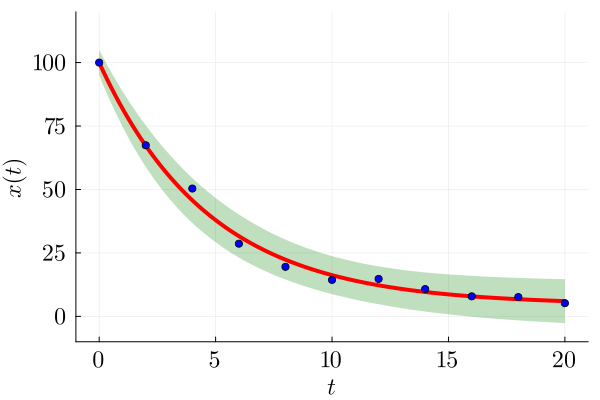

In [72]:
lower=100*ones(length(Tf)); #For each parameter sample within the 95% confidence set, solve the model on a fine discretisation
upper=-100*ones(length(Tf));
for i in 1:M
    xpred=model(Tf,[α1sample[i],α2sample[i]]);
     
        for j in 1:length(Tf)

            if xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[1] < lower[j] #Compute the lower bound of the prediction interval by computing the 0.05 quantile of the noise model
               lower[j]=xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
           
            if xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[2] > upper[j] #Compute the upper bound of the prediction interval by computing the 0.95 quantile of the noise model 
               upper[j] = xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end
           
        end
    
    end
    


q5=plot(Tf,lower,lw=0,fillrange=upper,fillalpha=0.25,color=:green,label=false) #Visualise the exact prediction interval
q5=plot!(Tf,xmle,lw=4,xlabel=L"t",ylabel=L"x(t)",color=:red,label=false)
q5=scatter!(T,data,mc=:blue,msc=:match,label=false)
q5=plot!(xlims=(minimum(Tf)-1,maximum(Tf)+1),xticks=([0,5,10,15,20],[L"0",L"5",L"10",L"15",L"20"]))
q5=plot!(ylims=(-10,120),yticks=([0,25,50,75,100],[L"0", L"25", L"50",L"75",L"100"]))
q5=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)    

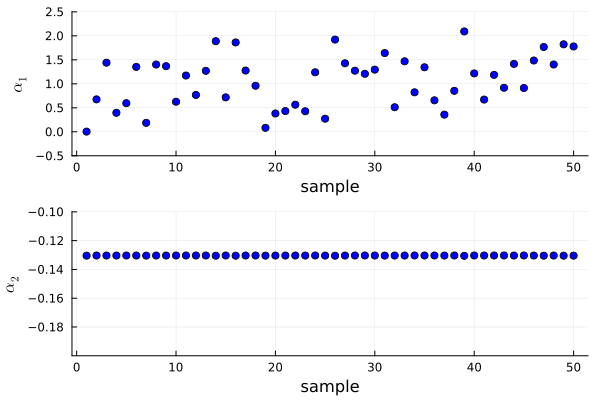

In [73]:
df=2 #Generate M parameter samples within the 95% confidence region by rejection sampling from the α1 univariate profile loglikelihood
llstar=-quantile(Chisq(df),0.95)/2
M=50
α1sample=zeros(M)
α2sample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
α1g=rand(Uniform(α1min,α1max))
α2g=Uα1(α1g)[2][1]

    if (loglhood(data,[α1g,α2g],T,σ)-fmle) >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(data,[α1g,α2g],T,σ)-fmle
    α1sample[kount]=α1g;
    α2sample[kount]=α2g;    
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"α_1",ylims=(α1min,α1max))
a2=scatter(α2sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"α_2",ylims=(α2min,α2max))
a3=plot(a1,a2,layout=(2,1))

In [74]:
U1lower=100*ones(length(Tf)); #Compute the upper and lower boundary of the prediction interval using the α1 profile likelihod function
U1upper=-100*ones(length(Tf));
for i in 1:M
    xpred=model(Tf,[α1sample[i],α2sample[i]]);
     
        for j in 1:length(Tf)

            if xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[1] < U1lower[j] 
               U1lower[j]=xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
           
            if xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[2] > U1upper[j] 
               U1upper[j] = xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end
           
        end
    
    end
      

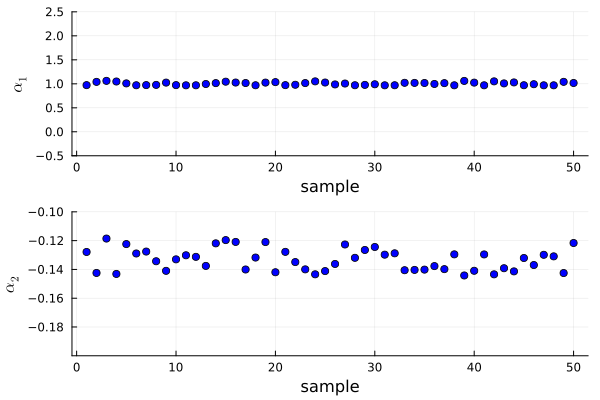

In [75]:
df=2 #Generate M parameter samples within the 95% confidence region by rejection sampling from the α2 univariate profile loglikelihood
llstar=-quantile(Chisq(df),0.95)/2
M=50
α1sample=zeros(M)
α2sample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
α2g=rand(Uniform(α2min,α2max))
α1g=Uα2(α2g)[2][1]

    if (loglhood(data,[α1g,α2g],T,σ)-fmle) >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(data,[α1g,α2g],T,σ)-fmle
    α1sample[kount]=α1g;
    α2sample[kount]=α2g;    
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"α_1",ylims=(α1min,α1max))
a2=scatter(α2sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"α_2",ylims=(α2min,α2max))
a3=plot(a1,a2,layout=(2,1))

In [76]:
U2lower=100*ones(length(Tf)); #Compute the upper and lower boundary of the prediction interval using the α2 profile likelihod function
U2upper=-100*ones(length(Tf));
for i in 1:M
    xpred=model(Tf,[α1sample[i],α2sample[i]]);
     
        for j in 1:length(Tf)

            if xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[1] < U2lower[j] 
               U2lower[j]=xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
           
            if xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[2] > U2upper[j] 
               U2upper[j] = xpred[j]+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end
           
        end
    
    end
      

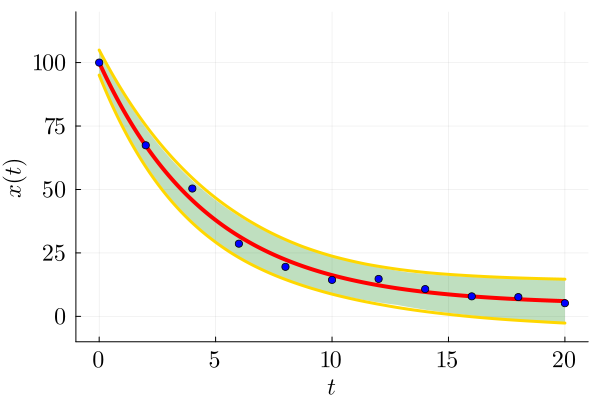

In [77]:
Unionlower=100*ones(length(Tf)); #Compute approximate upper and lower bounds by taking the union of the prediction intervals from the two univariate profiles 
Unionupper=-100*ones(length(Tf));

for j in 1:length(Tf)
Unionlower[j] = min(U1lower[j],U2lower[j])
Unionupper[j] = max(U1upper[j],U2upper[j])
end

q5=plot(Tf,Unionlower,lw=0,fillrange=Unionupper,fillalpha=0.25,color=:green,label=false) #Compare exact prediction interval and approximate prediction interval
q5=plot!(Tf,xmle,lw=4,xlabel=L"t",ylabel=L"x(t)",color=:red,label=false)
q5=plot!(Tf,lower,lc=:gold,lw=3,label=false)
q5=plot!(Tf,upper,lc=:gold,lw=3,label=false)
q5=scatter!(T,data,mc=:blue,msc=:match,label=false)
q5=plot!(xlims=(minimum(Tf)-1,maximum(Tf)+1),xticks=([0,5,10,15,20],[L"0",L"5",L"10",L"15",L"20"]))
q5=plot!(ylims=(-10,120),yticks=([0,25,50,75,100],[L"0", L"25", L"50",L"75",L"100"]))
q5=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)  
#savefig(q5,"ProductionDecay_Predicton_RescaledSVD.pdf")
display(q5)

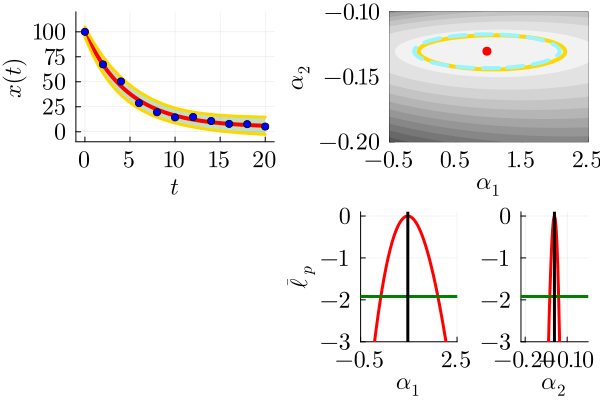

"C:\\Users\\matth\\Dropbox\\Model_Reduction\\Jupyter Notebooks\\Figure2b.pdf"

In [79]:
p9 = plot(legend=false,grid=false,foreground_color_subplot=:white)
s1=plot(q5,b1,p9,q4,layout=(2,2))
display(s1)
savefig(s1,"Figure2b.pdf")